In [1]:
from sklearn.decomposition import PCA
import numpy as np

In [37]:
import torch
from torch import nn
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from transformers import EsmModel, EsmTokenizer, AutoTokenizer, AutoModelForMaskedLM

class SeqEmbedder(nn.Module):
    def __init__(self, model_name="facebook/esm2_t6_8M_UR50D", device=None):
        super(SeqEmbedder, self).__init__()
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = EsmModel.from_pretrained(model_name).to(self.device)
        self.tokenizer = EsmTokenizer.from_pretrained(model_name)
        self.hidden_dim = self.model.config.hidden_size
        self.model._modules["pooler"] = nn.Identity()
        self.model._modules["contact_head"] = nn.Identity()


        for param in self.model.parameters():
            param.requires_grad = False

    def forward(self, seq):
        inputs = self.tokenizer(seq, return_tensors="pt", padding=True, truncation=True).to(self.device)

        with torch.no_grad():
            out = self.model(**inputs)

        embedding = out.last_hidden_state  
        embedding = embedding[:, :-1, :] # Remove EOS token. Shape = (batch_size, seq_len+1, hidden_dim1)
        embedding = embedding.squeeze(0)  # Remove batch dimension. Shape = (seq_len+1, hidden_dim1)

        return embedding  # Remove batch dimension. Shape = (seq_len+1, hidden_dim1)

In [38]:
def dimentionality_reduction(embedding, dimred = None):
    if dimred == 'PCA':
        pca = PCA(n_components=5)
        pca_embeddings = pca.fit_transform(embedding.flatten().reshape(len(embedding), -1))
        embedding = pca_embeddings
    elif dimred == 'UMAP':
        umap = UMAP(n_components=5)
        umap_embeddings = umap.fit_transform(embedding.flatten().reshape(len(embedding), -1))
        embedding = umap_embeddings
    elif dimred == 'TSNE':
        tsne = TSNE(n_components=5, perplexity=30, n_iter=300)
        tsne_embeddings = tsne.fit_transform(embedding.flatten().reshape(len(embedding), -1))
        embedding = tsne_embeddings
    else:
        raise ValueError("Unsupported dimensionality reduction method. Use 'PCA', 'UMAP', or 'TSNE'.")
    return embedding

In [23]:
import pandas as pd

df = pd.read_csv('/Users/nathanphan/Desktop/Projects/ncPPI/Benchmarking/visualization_folding_scores.csv')

In [4]:
scores = df['Energy Score'].values
mutated_sequences = df['Mutated Sequence'].values

In [5]:
print(len(mutated_sequences))

117


In [39]:
mutated_embeddings = []
for seq in mutated_sequences:
    seq_embedder = SeqEmbedder()  # Change 'PCA' to 'UMAP' or 'TSNE' as needed
    embedding = seq_embedder(seq)
    mutated_embeddings.append(embedding)
mutated_embeddings = np.array(mutated_embeddings)



Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 

In [40]:
print(mutated_embeddings.shape)

(117, 119, 320)


In [41]:
dimred_embedding = dimentionality_reduction(mutated_embeddings, dimred='PCA')  # Change 'PCA' to 'UMAP' or 'TSNE' as needed

In [42]:
dimred_embedding.shape

(117, 5)

In [7]:
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(mutated_embeddings.flatten().reshape(len(mutated_embeddings), -1))

In [8]:
from umap import UMAP
down = UMAP(n_components=2, random_state=42)

In [9]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(mutated_embeddings.flatten().reshape(len(mutated_embeddings), -1))

In [10]:
print(mutated_embeddings.shape)

(117, 119, 320)


In [11]:
umap_embeddings = down.fit_transform(mutated_embeddings.flatten().reshape(len(mutated_embeddings), -1))

/Users/nathanphan/anaconda3/envs/ncaa/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [12]:
print(type(mutated_embeddings[0]))

<class 'numpy.ndarray'>


In [13]:
mutated_embeddings = np.array(mutated_embeddings)

In [14]:
print(len(mutated_embeddings[1]))

119


In [15]:
print(mutated_embeddings.shape)

(117, 119, 320)


In [26]:
scores = df['Folded Energy Delta'].values
scores = scores.astype(float)
scores = np.log1p(scores)  # Apply log1p transformation to scores
array = np.array(scores)
mass = np.hstack((pca_embeddings, array.reshape(-1, 1)))
mass2 = np.hstack((umap_embeddings, array.reshape(-1, 1)))

Number of data points: 117


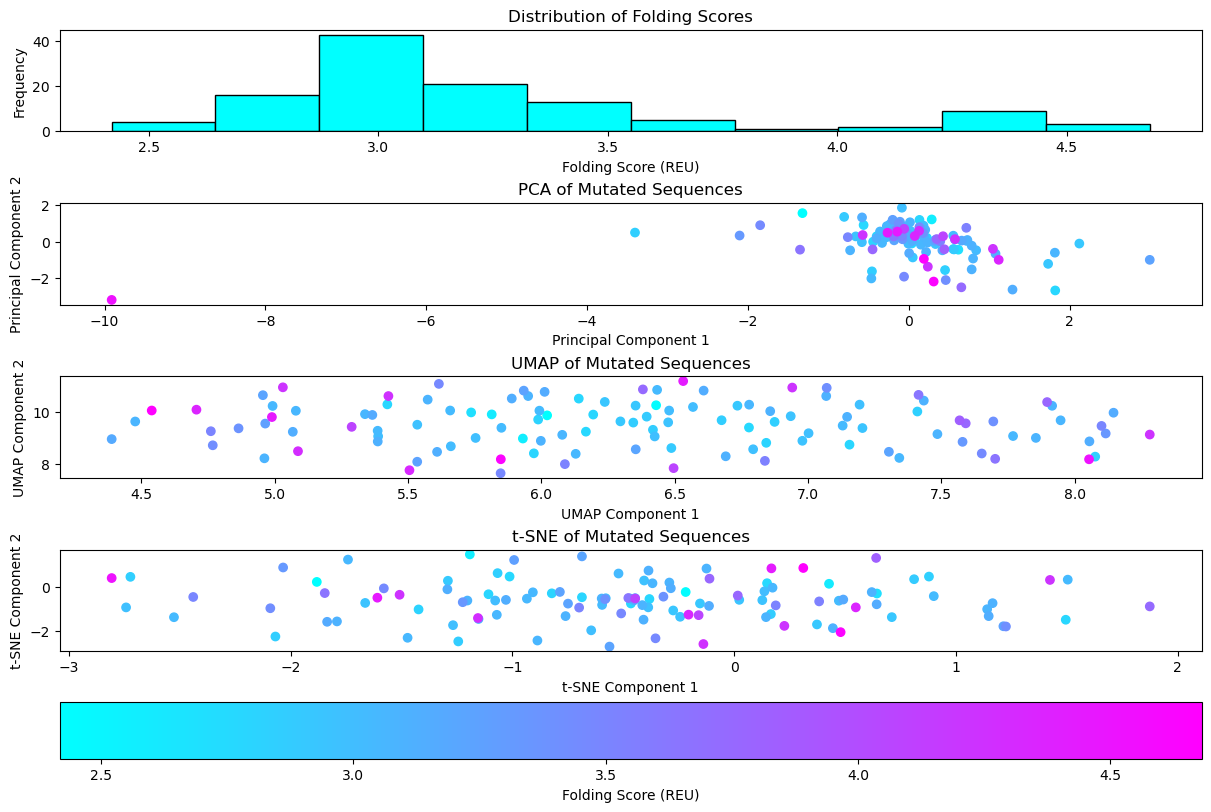

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Create the figure and subplots
fig, axs = plt.subplots(4, 1, figsize=(12, 8), constrained_layout=True)

# Assuming you have your data variables defined:
# scores, mass, mass2, tsne_embeddings

print(f"Number of data points: {len(mass[:, 0])}")

# Plot 1: Histogram of energy scores
axs[0].set_title('Distribution of Folding Scores')
axs[0].set_xlabel('Folding Score (REU)')
axs[0].set_ylabel('Frequency')
axs[0].hist(scores, bins=10, color='cyan', edgecolor='black')

# Plot 2: PCA scatter plot
scatter1 = axs[1].scatter(mass[:, 0], mass[:, 1], c=mass[:, 2], cmap='cool')
axs[1].set_title('PCA of Mutated Sequences')
axs[1].set_xlabel('Principal Component 1')
axs[1].set_ylabel('Principal Component 2')

# Plot 3: UMAP scatter plot
scatter2 = axs[2].scatter(mass2[:, 0], mass2[:, 1], c=mass2[:, 2], cmap='cool')
axs[2].set_title('UMAP of Mutated Sequences')
axs[2].set_xlabel('UMAP Component 1')
axs[2].set_ylabel('UMAP Component 2')

# Plot 4: t-SNE scatter plot
scatter3 = axs[3].scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=mass2[:, 2], cmap='cool')
axs[3].set_title('t-SNE of Mutated Sequences')
axs[3].set_xlabel('t-SNE Component 1')
axs[3].set_ylabel('t-SNE Component 2')

# Add colorbar - fix the syntax

# Adjust layout


# Optional: Set axis limits if needed
# axs[1].set_xlim(-0.5, 0.5)
# axs[1].set_ylim(-0.5, 0.5)
fig.colorbar(scatter1, ax=axs, orientation='horizontal', location='bottom', label='Folding Score (REU)', pad = 0.01)
# fig.tight_layout()
plt.savefig('log_visualization_folding_scores.png', dpi=300)
plt.show()